In [1]:
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" #for training on gpu

from scipy import signal
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
from random import shuffle
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Conv1D, MaxPooling1D, Dropout, GlobalAveragePooling1D, Reshape

#path to data files
path = "./nine_movs_six_sub_split/"

#path where you want to save trained model and some other files
sec_path = "./"

def create_dataset(file_path, persons):
    path = file_path + "{}_{}.txt"
    sgn = []
    lbl = []
    for i in persons:
        for j in range(9):
            with open(path.format(i, j + 1), "rb") as fp:  # Unpickling
                data = pickle.load(fp)

            for k in range(np.shape(data)[0]):
                sgn.append(data[k])
                lbl.append(j)

    sgn = np.asarray(sgn, dtype=np.float32)
    lbl = np.asarray(lbl, dtype=np.int32)

    c = list(zip(sgn, lbl))
    shuffle(c)
    sgn, lbl = zip(*c)

    sgn = np.asarray(sgn, dtype=np.float64)
    lbl = np.asarray(lbl, dtype=np.int64)

    print(sgn.shape)

    train_signals = sgn[0:int(0.8 * len(sgn))]
    train_labels = lbl[0:int(0.8 * len(lbl))]
    val_signals = sgn[int(0.8*len(sgn)):]
    val_labels = lbl[int(0.8*len(lbl)):]
    #test_signals = sgn[int(0.8*len(sgn)):]
    #test_labels = lbl[int(0.8*len(lbl)):]

    train_labels = to_categorical(train_labels)
    val_labels = to_categorical(val_labels)
    #test_labels = to_categorical(test_labels)

    return train_signals, train_labels, val_signals, val_labels

def create_dataset2(file_path, persons):
    path = file_path + "{}_{}.txt"
    sgn = []
    lbl = []
    i = persons
    for j in range(9):
        with open(path.format(i, j + 1), "rb") as fp:  # Unpickling
            data = pickle.load(fp)

        for k in range(np.shape(data)[0]):
             sgn.append(data[k])
             lbl.append(j)

    sgn = np.asarray(sgn, dtype=np.float32)
    lbl = np.asarray(lbl, dtype=np.int32)

    c = list(zip(sgn, lbl))
    shuffle(c)
    sgn, lbl = zip(*c)

    sgn = np.asarray(sgn, dtype=np.float64)
    lbl = np.asarray(lbl, dtype=np.int64)

    print(sgn.shape)

    train_signals = sgn[0:int(0.6 * len(sgn))]
    train_labels = lbl[0:int(0.6 * len(lbl))]
    val_signals = sgn[int(0.6*len(sgn)):int(0.8*len(sgn))]
    val_labels = lbl[int(0.6*len(lbl)):int(0.8*len(lbl))]
    test_signals = sgn[int(0.8*len(sgn)):]
    test_labels = lbl[int(0.8*len(lbl)):]

    train_labels = to_categorical(train_labels)
    val_labels = to_categorical(val_labels)
    test_labels = to_categorical(test_labels)

    return train_signals, train_labels, val_signals, val_labels, test_signals, test_labels


def evaluate_model(model, expected_person_index = 2):
    print("evaluate_model, expected_person_index:", expected_person_index)
    persons = [1, 2, 3, 4, 5, 6]
    persons.remove(expected_person_index)
    train_signals, train_labels, val_signals, val_labels = create_dataset(path, persons)
    model.evaluate(train_signals, train_labels)

    train_signals, train_labels, val_signals, val_labels, test_signals, test_labels = create_dataset2(path, expected_person_index)
    model.evaluate(train_signals, train_labels)

    
def plot_history(history):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Эпоха')
    plt.ylabel('Вероятность корректного распознавания')
    #plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.grid(True)
    print(history.history['val_accuracy'])

# training model on 5 form 6 persons
a = [1, 3, 4, 5, 6]
train_signals, train_labels, val_signals, val_labels = create_dataset(path, a)

(2329, 400)


In [2]:
num_classes = 9
num_sensors = 1
input_size = train_signals.shape[1]

model = Sequential()
model.add(Reshape((input_size, num_sensors), input_shape=(input_size, )))
model.add(Conv1D(50, 10, activation='relu', input_shape=(input_size, num_sensors)))
model.add(Conv1D(25, 10, activation='relu'))
model.add(MaxPooling1D(4))
model.add(Conv1D(100, 10, activation='relu'))
model.add(Conv1D(50, 10, activation='relu'))
model.add(MaxPooling1D(4))
model.add(Dropout(0.5))
#next layers will be retrained
model.add(Conv1D(100, 10, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dense(num_classes, activation='softmax'))


model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])


#elapsed_time = time.time() - start_time # training time

#loss, accuracy = model.evaluate(val_signals, val_labels) # evaluating model on test data

#loss = float("{0:.3f}".format(loss))
#accuracy = float("{0:.3f}".format(accuracy))
#elapsed_time = float("{0:.3f}".format(elapsed_time))

#saving some data
#f = open(sec_path + "info.txt", 'w')
#f.writelines(["loss: ", str(loss), '\n', "accuracy: ", str(accuracy), '\n', "elapsed_time: ", str(elapsed_time), '\n'])

#saving model
#model.save(sec_path + "pretrained_model.h5")

#saving test data just in case
#cc = list(zip(test_signals, test_labels))
#with open(sec_path + "pretrained_model_test_data.txt", "wb") as fp:
#   pickle.dump(cc, fp)

#saving history
#with open(sec_path + "pretrained_model_history.h5", "wb") as fp:
#    pickle.dump(history.history, fp)


In [3]:
start_time = time.time()

history = model.fit(train_signals, train_labels,
                      steps_per_epoch=25,
                      epochs=100,
                      batch_size=None,
                      validation_data=(val_signals, val_labels),
                      #validation_steps=25
)

Epoch 1/100
25/25 [==============================] - 2s 83ms/step - loss: 2.4083 - accuracy: 0.1278 - val_loss: 2.0610 - val_accuracy: 0.1202
Epoch 2/100
25/25 [==============================] - 2s 74ms/step - loss: 2.0088 - accuracy: 0.1385 - val_loss: 2.0004 - val_accuracy: 0.2232
Epoch 3/100
25/25 [==============================] - 2s 75ms/step - loss: 1.9445 - accuracy: 0.2126 - val_loss: 1.9457 - val_accuracy: 0.2318
Epoch 4/100
25/25 [==============================] - 2s 75ms/step - loss: 1.8479 - accuracy: 0.2738 - val_loss: 1.7933 - val_accuracy: 0.3219
Epoch 5/100
25/25 [==============================] - 2s 77ms/step - loss: 1.7288 - accuracy: 0.3124 - val_loss: 1.5788 - val_accuracy: 0.4056
Epoch 6/100
25/25 [==============================] - 2s 82ms/step - loss: 1.5645 - accuracy: 0.4079 - val_loss: 1.4171 - val_accuracy: 0.4206
Epoch 7/100
25/25 [==============================] - 2s 76ms/step - loss: 1.3737 - accuracy: 0.4665 - val_loss: 1.2065 - val_accuracy: 0.5451
Epoch 

25/25 [==============================] - 2s 72ms/step - loss: 0.0795 - accuracy: 0.9758 - val_loss: 0.4050 - val_accuracy: 0.8948
Epoch 59/100
25/25 [==============================] - 2s 71ms/step - loss: 0.0863 - accuracy: 0.9694 - val_loss: 0.3648 - val_accuracy: 0.9013
Epoch 60/100
25/25 [==============================] - 2s 71ms/step - loss: 0.0855 - accuracy: 0.9764 - val_loss: 0.3616 - val_accuracy: 0.9013
Epoch 61/100
25/25 [==============================] - 2s 70ms/step - loss: 0.0908 - accuracy: 0.9694 - val_loss: 0.3309 - val_accuracy: 0.8991
Epoch 62/100
25/25 [==============================] - 2s 74ms/step - loss: 0.0842 - accuracy: 0.9742 - val_loss: 0.4051 - val_accuracy: 0.8820
Epoch 63/100
25/25 [==============================] - 2s 89ms/step - loss: 0.0634 - accuracy: 0.9758 - val_loss: 0.3325 - val_accuracy: 0.9013
Epoch 64/100
25/25 [==============================] - 2s 84ms/step - loss: 0.0642 - accuracy: 0.9812 - val_loss: 0.3467 - val_accuracy: 0.8863
Epoch 65/100

In [4]:
train_signals, train_labels, val_signals, val_labels, test_signals, test_labels = create_dataset2(path, 2)

(491, 400)


[0.1201716735959053, 0.22317597270011902, 0.23175965249538422, 0.32188841700553894, 0.4055793881416321, 0.42060086131095886, 0.545064389705658, 0.6094420552253723, 0.6630901098251343, 0.6845493316650391, 0.7424892783164978, 0.7274678349494934, 0.7446351647377014, 0.7446351647377014, 0.8047210574150085, 0.7639485001564026, 0.8004291653633118, 0.8068669438362122, 0.832617998123169, 0.8390557765960693, 0.8476395010948181, 0.832617998123169, 0.8562231659889221, 0.8540772795677185, 0.8476395010948181, 0.8626609444618225, 0.8690987229347229, 0.8540772795677185, 0.8755365014076233, 0.8690987229347229, 0.8540772795677185, 0.8626609444618225, 0.8648068904876709, 0.8798283338546753, 0.8862661123275757, 0.8755365014076233, 0.8798283338546753, 0.8905579447746277, 0.8755365014076233, 0.8905579447746277, 0.8948497772216797, 0.8776823878288269, 0.8862661123275757, 0.8776823878288269, 0.8969957232475281, 0.8755365014076233, 0.8969957232475281, 0.9163089990615845, 0.8819742202758789, 0.8776823878288269

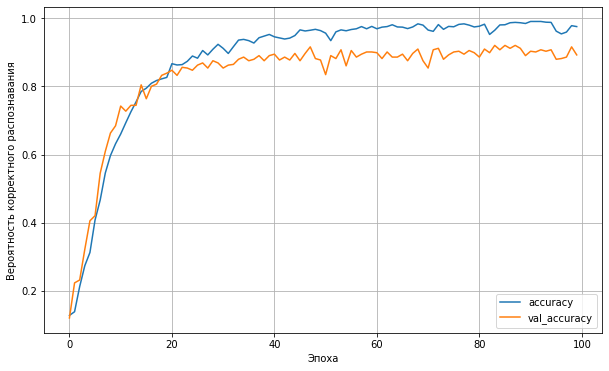

In [5]:
plot_history(history)

In [6]:
evaluate_model(model, 2)

evaluate_model, expected_person_index: 2
(2329, 400)
59/59 [==============================] - 0s 7ms/step - loss: 0.1076 - accuracy: 0.9721
(491, 400)
10/10 [==============================] - 0s 6ms/step - loss: 4.5096 - accuracy: 0.3810


(11, 1, 1)
10/10 [==============================] - 0s 6ms/step - loss: 4.8465 - accuracy: 0.3707


[4.846508026123047, 0.3707483112812042]

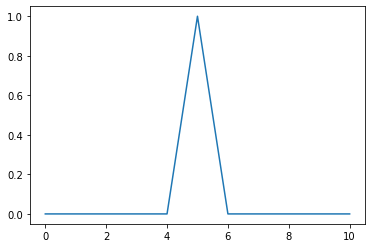

In [34]:
checkpoin_weights = []

for l in model.layers:
  checkpoin_weights.append(l.get_weights())


model2 = Sequential()
model2.add(Reshape((input_size, num_sensors), input_shape=(input_size, )))
# Новый слой (КИХ фильтра)
# 1 свертка из 11 чисел
length_of_conv_filter = 11
model2.add(Conv1D(1, length_of_conv_filter, activation='linear', input_shape=(input_size, num_sensors), padding='same', name="Filter"))
model2.add(Dropout(0.5))
model2.add(Conv1D(50, 10, activation='relu', input_shape=(input_size, num_sensors), trainable='False'))
model2.add(Conv1D(25, 10, activation='relu', trainable='False'))
model2.add(MaxPooling1D(4))
model2.add(Conv1D(100, 10, activation='relu', trainable='False'))
model2.add(Conv1D(50, 10, activation='relu', trainable='False'))
model2.add(MaxPooling1D(4))
model2.add(Dropout(0.5))
#next layers will be retrained
model2.add(Conv1D(100, 10, activation='relu', trainable='False'))
model2.add(GlobalAveragePooling1D())
model2.add(Dense(num_classes, activation='softmax', trainable='False'))

#for i in range(1, 11):
#  model2.layers[i+1].set_weights(checkpoin_weights[i])

w = model2.layers[1].get_weights()
print(w[0].shape)

# Подбираем параметры для первого слоя КИХ фильтра
w[0] = w[0] * 0
w[0][int(length_of_conv_filter/2),0,0] = 1
w[1] = w[1]*0
plt.plot(w[0].flatten())

w = model2.layers[1].set_weights(w)

# Устанавливаем веса для уже обученных слоев
n_layers = 11
for i in range(1, n_layers):
    model2.layers[i+2].set_weights(checkpoin_weights[i])
#    model2.layers[i+1].trainable = False

model2.compile(loss='categorical_crossentropy',
             optimizer='adam', metrics=['accuracy'])

model2.evaluate(train_signals, train_labels)

# !tensorboard dev upload --logdir ./ \
#   --name "Simple experiment" \
#   --description "Training results from https://colab.sandbox.google.com/github/tensorflow/tensorboard/blob/master/docs/tbdev_getting_started.ipynb" \
#   --one_shot
# !tensorboard dev list
#keras.utils.plot_model(model2, 'dense_image_classifier.png', show_shapes=True)


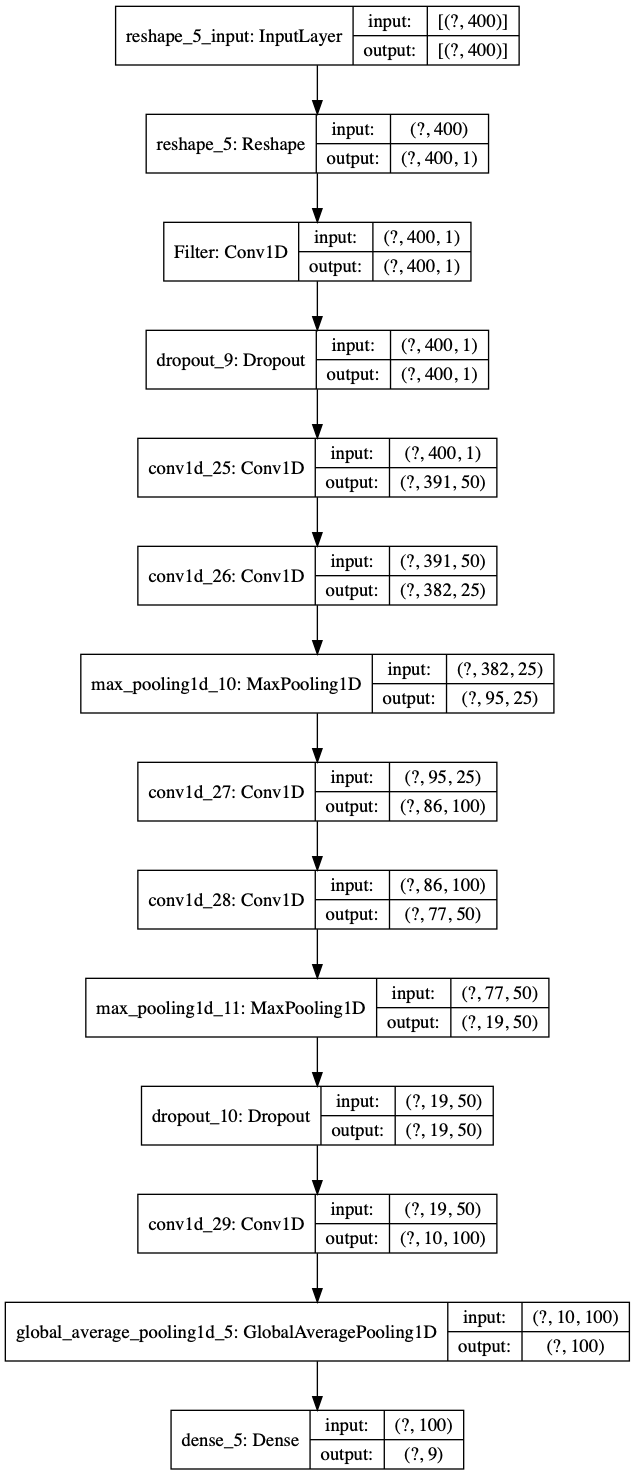

In [12]:

keras.utils.plot_model(model2, 'dense_image_classifier2.png', show_shapes=True)

In [ ]:
#keras.utils.plot_model(model2, 'dense_image_classifier.png', show_shapes=True)

In [37]:
history2 = model2.fit(train_signals, train_labels, epochs=25, 
                   validation_data=(test_signals, test_labels))

Epoch 1/25
10/10 [==============================] - 0s 48ms/step - loss: 9.0262 - accuracy: 0.2721 - val_loss: 2.5280 - val_accuracy: 0.3737
Epoch 2/25
10/10 [==============================] - 0s 44ms/step - loss: 2.3075 - accuracy: 0.3299 - val_loss: 1.8942 - val_accuracy: 0.3434
Epoch 3/25
10/10 [==============================] - 0s 41ms/step - loss: 1.7573 - accuracy: 0.2959 - val_loss: 1.7240 - val_accuracy: 0.3232
Epoch 4/25
10/10 [==============================] - 0s 40ms/step - loss: 1.7106 - accuracy: 0.3741 - val_loss: 1.7228 - val_accuracy: 0.2727
Epoch 5/25
10/10 [==============================] - 0s 41ms/step - loss: 1.5922 - accuracy: 0.4320 - val_loss: 1.6169 - val_accuracy: 0.3030
Epoch 6/25
10/10 [==============================] - 0s 48ms/step - loss: 1.6305 - accuracy: 0.3673 - val_loss: 1.5581 - val_accuracy: 0.3535
Epoch 7/25
10/10 [==============================] - 0s 44ms/step - loss: 1.4494 - accuracy: 0.4660 - val_loss: 1.7406 - val_accuracy: 0.2626
Epoch 8/25
10

[0.31313130259513855, 0.27272728085517883, 0.2525252401828766, 0.31313130259513855, 0.24242424964904785, 0.31313130259513855, 0.27272728085517883, 0.4343434274196625, 0.42424243688583374, 0.5151515007019043, 0.5353535413742065, 0.6161616444587708, 0.5353535413742065, 0.6262626051902771, 0.6060606241226196, 0.7373737096786499, 0.5858585834503174, 0.7070707082748413, 0.6363636255264282, 0.6767676472663879, 0.6767676472663879, 0.6969696879386902, 0.747474730014801, 0.6969696879386902, 0.7171717286109924]


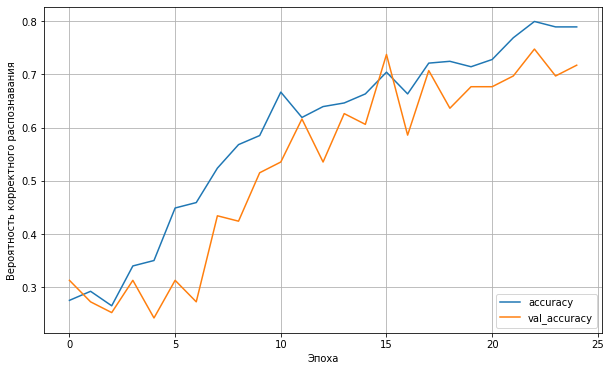

In [14]:


plot_history(history2)

#функция вывода коэффициентов свёрточного слоя
def check_coef_conv_layer(model_name, num_layer, num_filter):
  
  #сохраняем в переменную коэффициенты наблюдаемого слоя
  layer = model_name.layers[num_layer].get_weights()

  #коэффициенты 'а' наблюдаемого слоя первой сети 
  weights = layer[0]
  #коэффициенты 'b' наблюдаемого слоя первой сети 
  biases = layer[1]
  #вывод данных на экран
  for i in range(10):
    print("k{} = {:7.4f}".format(i, weights[i][0][num_filter]))
  print("\nb = {:7.4f}".format(biases[num_filter]))
    
#функция вывода коеффициентов полносвязного слоя
def check_coef_dense_layer(model_name, num_layer, num_filter):

  #сохраняем в переменную веса наблюдаемого слоя сети
  layer = model_name.layers[num_layer].get_weights()

  #коэффициенты 'а' наблюдаемого слоя сети 
  weights = layer[0]
  #коэффициенты 'b' наблюдаемого слоя сети 
  biases = layer[1]
  #вывод данных на экран
  for i in range(10):
    print("k{} = {:7.4f}".format(i, weights[i][num_filter]))
  print("\nb = {:7.4f}".format(biases[num_filter]))

l = model.layers[10].get_weights()


[0.8181818127632141, 0.8585858345031738, 0.808080792427063, 0.8585858345031738, 0.8585858345031738, 0.8383838534355164, 0.8787878751754761, 0.8282828330993652, 0.7979797720909119, 0.7878788113594055, 0.8383838534355164, 0.868686854839325, 0.8888888955116272, 0.8383838534355164, 0.8383838534355164, 0.868686854839325, 0.8282828330993652, 0.8585858345031738, 0.9191918969154358, 0.8888888955116272, 0.8484848737716675, 0.8181818127632141, 0.8484848737716675, 0.8484848737716675, 0.9090909361839294]


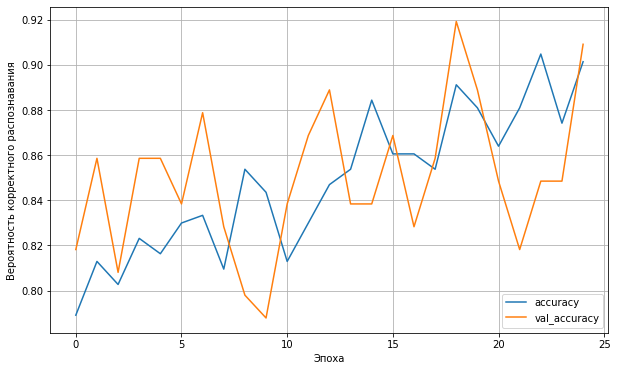

In [36]:
plot_history(history2)

In [38]:

evaluate_model(model2, 2)
# keras.utils.plot_model(model, 'dense_image_classifier.png', show_shapes=True)

evaluate_model, expected_person_index: 2
(2329, 400)
59/59 [==============================] - 0s 8ms/step - loss: 3.1865 - accuracy: 0.3768
(491, 400)
10/10 [==============================] - 0s 6ms/step - loss: 0.6444 - accuracy: 0.7755


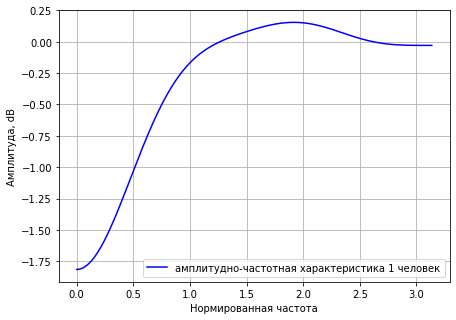

In [39]:
b = model2.layers[1].get_weights()
# b[0] - neurons weights
w, h = signal.freqz(b[0].flatten())

plt.figure(figsize=(7, 5))
plt.plot(w, 20 * np.log10(abs(h)), 'b', label='амплитудно-частотная характеристика 1 человек')
plt.grid(True)
plt.xlabel('Нормированная частота')
plt.ylabel('Амплитуда, dB')
plt.legend(loc='lower right')
#print(b[0])
    
#plt.set_xlabel('Frequency [rad/sample]')
#plt.set_ylabel('Amplitude [dB]', color='b')

[-0.00124382 -0.00470856 -0.01049969 -0.0275067  -0.03647366  0.9684675
 -0.03014984 -0.02630629 -0.01018851 -0.00592093 -0.00405507]
0.036473658


Text(0.5, 1.0, 'импульсная характеристика')

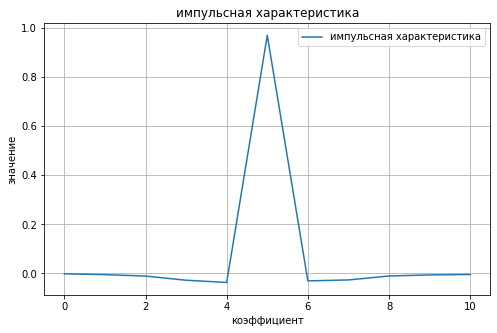

In [40]:
plt.figure(figsize=(8,5))
print(b[0].flatten())
print(abs(b[0].flatten().min()))
# plt.plot(np.log10(b[0].flatten()+0.1), label='импульсная характеристика')
plt.plot(b[0].flatten(), label='импульсная характеристика')
plt.grid(True)
plt.xlabel('коэффициент')
plt.ylabel('значение')
plt.legend(loc='upper right')
plt.title('импульсная характеристика')

In [ ]:
plt.plot(b[0].flatten())
print(b[0].flatten())

In [ ]:
# Обучаем теперь на третьем субъекте

train_signals, train_labels, val_signals, val_labels, test_signals, test_labels = create_dataset2(path, 3)
model.evaluate(train_signals, train_labels)
history2 = model2.fit(train_signals, train_labels, epochs=25, 
                   validation_data=(test_signals, test_labels))

In [ ]:

evaluate_model(model2, 3)